In [65]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
from bs4 import BeautifulSoup
import re

In [19]:
exposure_table = Table.read('extended_exposure_data.ecsv').to_pandas()

In [20]:
no_gust = exposure_table['WIND_GUST_SUM']==0
no_shake = exposure_table['WIND_SHAKE_SUM']==0
no_wind_speed = exposure_table['WIND_SPEED_AVG']<1E-5
print(np.count_nonzero(no_gust))
print(np.count_nonzero(no_shake))
print(np.count_nonzero(no_wind_speed))
print(len(exposure_table))

14240
15966
5216
21030


In [35]:
ii = ~(no_wind_speed)
print(np.count_nonzero(ii))
new_exposure_table = exposure_table[ii]

15814


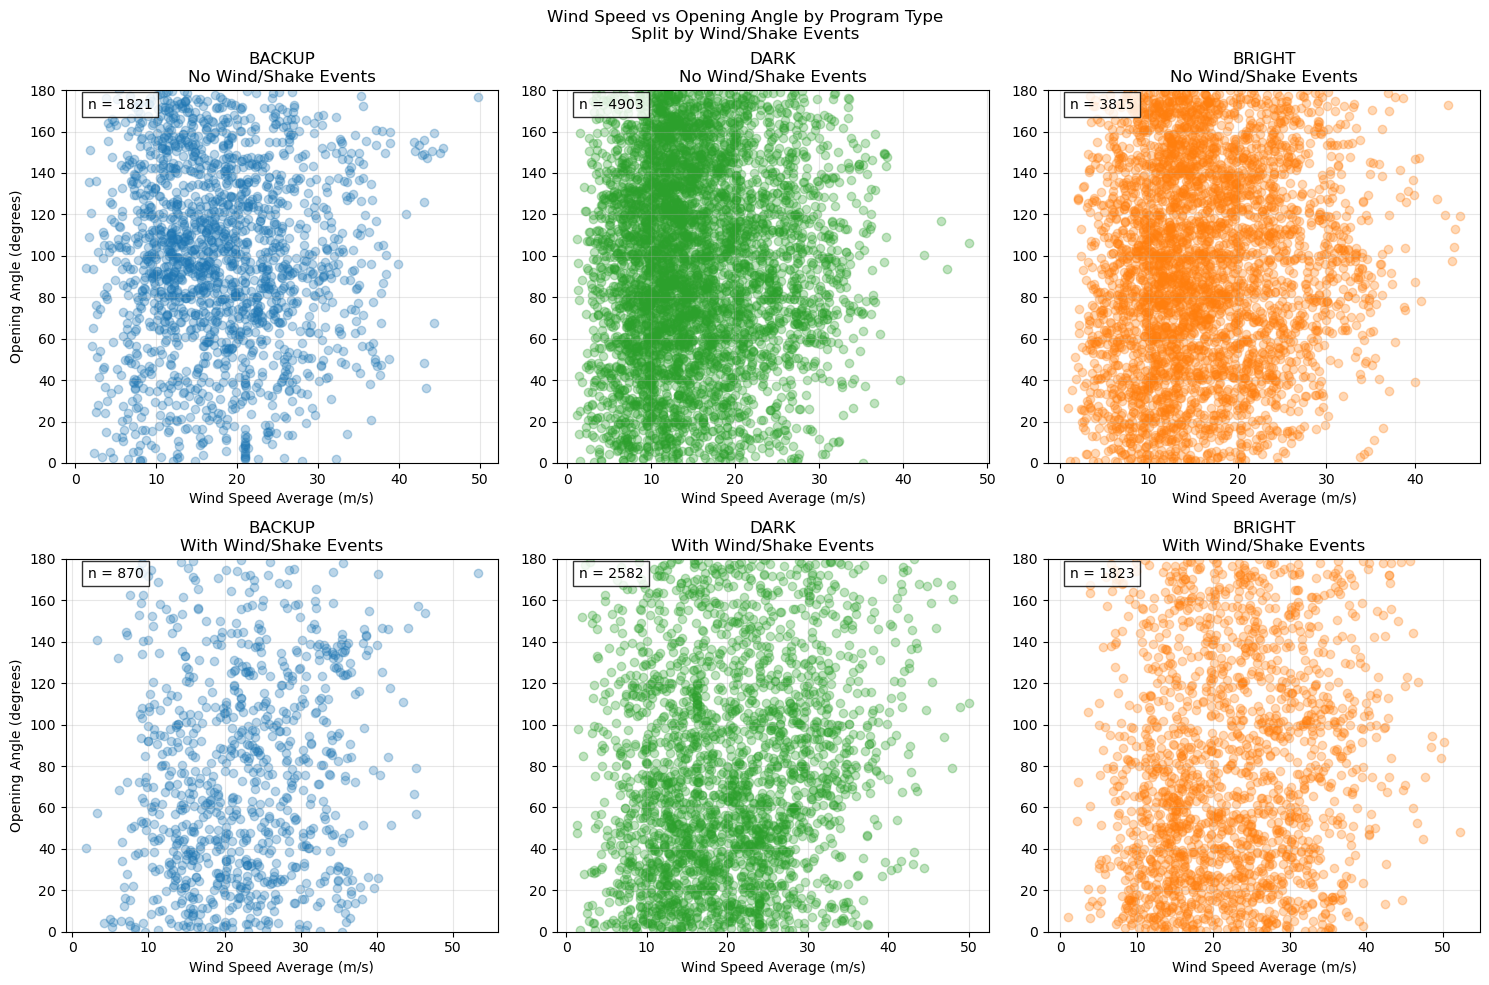

In [36]:
def plot_wind_speed_vs_angle_split(df):
    """
    Create a six-panel scatter plot of wind speed vs opening angle,
    separated by program type and presence/absence of wind/shake events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type\nSplit by Wind/Shake Events')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Create scatter plot for each program and condition
    for col, (program, color) in enumerate(zip(programs, colors)):
        for row, has_events in enumerate([False, True]):
            ax = axes[row, col]
            
            # Create mask for program and wind/shake condition
            program_mask = df['PROGRAM'] == program
            if has_events:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
                title_prefix = 'With'
            else:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
                title_prefix = 'No'
            
            combined_mask = program_mask & event_mask
            program_data = df[combined_mask]
            
            # Create scatter plot
            ax.scatter(program_data['WIND_SPEED_AVG'], 
                      program_data['WIND_OPENING_ANGLE'],
                      alpha=0.3, c=color, label=program)
            
            # Add labels
            ax.set_xlabel('Wind Speed Average (m/s)')
            if col == 0:
                ax.set_ylabel('Opening Angle (degrees)')
            ax.set_title(f'{program}\n{title_prefix} Wind/Shake Events')
            
            # Set y-axis limits
            ax.set_ylim(0, 180)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add count of points
            count = len(program_data)
            ax.text(0.05, 0.95, f'n = {count}', 
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig('summary.jpg')
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle_split(new_exposure_table)

# Display the plot
#plt.show()

In [37]:
def plot_cumulative_distributions(df):
    """
    Create three-panel plot showing cumulative distributions of wind speed,
    opening angle, and wind gust sum for each program type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Cumulative Distributions by Program Type')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    colors = ['#1f77b4', '#2ca02c', '#ff7f0e']  # blue, green, orange
    
    # Variables to plot with their labels
    variables = ['WIND_SPEED_AVG', 'WIND_OPENING_ANGLE', 'WIND_SHAKE_SUM']
    xlabels = ['Wind Speed (m/s)', 'Opening Angle (degrees)', 'Wind Shake Sum']
    
    # Create plots for each variable
    for ax, var, xlabel in zip(axes, variables, xlabels):
        for program, color in zip(programs, colors):
            # Get data for this program
            mask = df['PROGRAM'] == program
            data = df[mask][var].dropna()
            
            # Sort data and calculate cumulative distribution
            sorted_data = np.sort(data)
            cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            # Plot
            ax.plot(sorted_data, cumulative, 
                   label=f'{program} (n={len(data)})',
                   color=color, linewidth=2)
        
        # Customize each subplot
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Cumulative Fraction' if ax == axes[0] else '')
        ax.legend()
        
        # Set y-axis limits
        ax.set_ylim(0, 1.05)
        
    # Adjust layout
    plt.tight_layout()
    
    return fig, axes

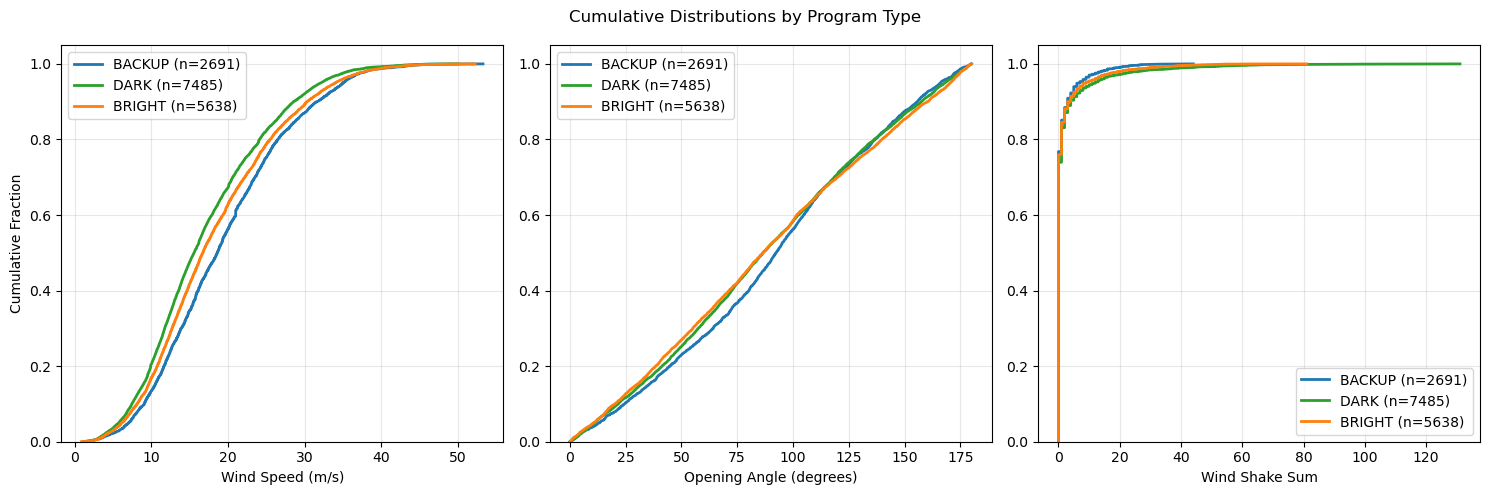

In [38]:
# Create the plot
fig, axes = plot_cumulative_distributions(new_exposure_table)

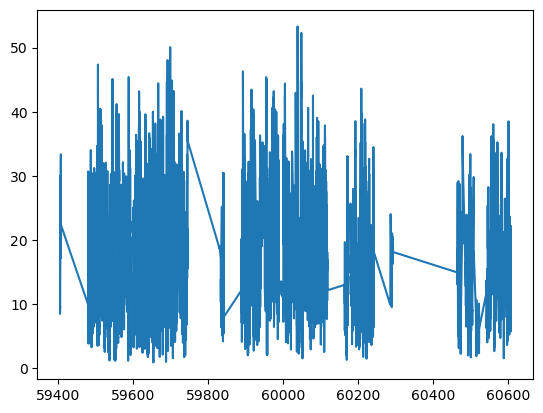

In [39]:
plt.plot(new_exposure_table['MJD'], new_exposure_table['WIND_SPEED_AVG'])

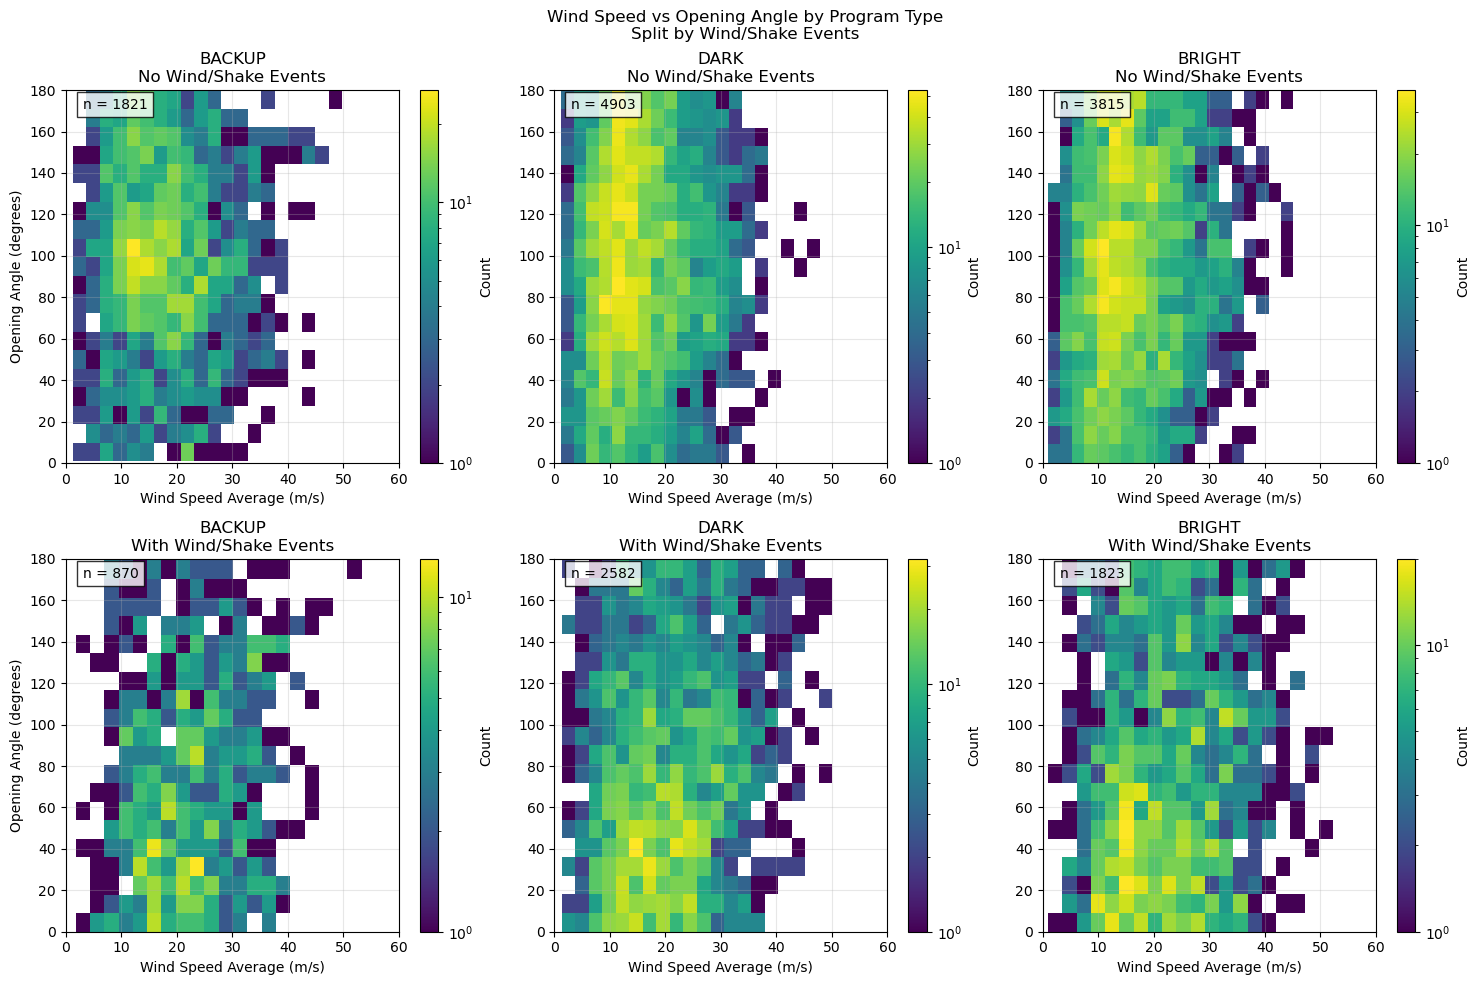

In [43]:
def plot_wind_speed_vs_angle_2dhist(df):
    """
    Create a six-panel 2D histogram of wind speed vs opening angle,
    separated by program type and presence/absence of wind/shake events.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing columns: 
        PROGRAM, WIND_SPEED_AVG, WIND_OPENING_ANGLE, WIND_GUST_SUM, WIND_SHAKE_SUM
    """
    # Set up the figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Wind Speed vs Opening Angle by Program Type\nSplit by Wind/Shake Events')
    
    # Define colors and programs
    programs = ['BACKUP', 'DARK', 'BRIGHT']
    
    # Create histogram for each program and condition
    for col, program in enumerate(programs):
        for row, has_events in enumerate([False, True]):
            ax = axes[row, col]
            
            # Create mask for program and wind/shake condition
            program_mask = df['PROGRAM'] == program
            if has_events:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) > 0
                title_prefix = 'With'
            else:
                event_mask = (df['WIND_GUST_SUM'] + df['WIND_SHAKE_SUM']) == 0
                title_prefix = 'No'
            
            combined_mask = program_mask & event_mask
            program_data = df[combined_mask]
            
            # Create 2D histogram
            hist = ax.hist2d(program_data['WIND_SPEED_AVG'], 
                           program_data['WIND_OPENING_ANGLE'],
                           bins=(20, 20),  # You can adjust the number of bins
                           cmap='viridis',
                           norm=plt.matplotlib.colors.LogNorm())  # Use log scale for better visualization
            
            # Add colorbar
            plt.colorbar(hist[3], ax=ax, label='Count')
            
            # Add labels
            ax.set_xlabel('Wind Speed Average (m/s)')
            if col == 0:
                ax.set_ylabel('Opening Angle (degrees)')
            ax.set_title(f'{program}\n{title_prefix} Wind/Shake Events')
            
            # Set y-axis limits
            ax.set_ylim(0, 180)
            ax.set_xlim(0,60)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add count of points
            count = len(program_data)
            ax.text(0.05, 0.95, f'n = {count}', 
                    transform=ax.transAxes,
                    bbox=dict(facecolor='white', alpha=0.8))
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    return fig, axes

# Create the plot
fig, axes = plot_wind_speed_vs_angle_2dhist(new_exposure_table)
plt.savefig('summary_2d.jpg')


In [49]:
dark_high_speed = (new_exposure_table['WIND_SPEED_AVG']>30.0) & (new_exposure_table['PROGRAM']=='DARK')
with_shake = (new_exposure_table['WIND_SHAKE_SUM']+new_exposure_table['WIND_GUST_SUM'])>0
print(np.count_nonzero(dark_high_speed & with_shake))
print(np.count_nonzero(dark_high_speed & ~with_shake))

382
210


In [52]:
print(new_exposure_table[dark_high_speed & with_shake][['EXPID', 'TIMESTAMP']])

        EXPID               TIMESTAMP
771    102089 2021-09-29 05:00:38.333
772    102090 2021-09-29 05:17:43.814
875    103123 2021-10-06 04:14:10.810
932    103343 2021-10-08 10:17:16.742
933    103344 2021-10-08 10:38:27.168
...       ...                     ...
19971  252090 2024-09-08 11:13:01.027
20459  255596 2024-09-29 04:05:48.221
20460  255597 2024-09-29 04:32:08.304
20461  255598 2024-09-29 04:54:34.243
20462  255599 2024-09-29 05:24:19.267

[382 rows x 2 columns]


In [69]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pytz
from bs4 import BeautifulSoup
import re

def get_nightlog_path(timestamp):
    """
    Convert UTC timestamp to the corresponding local nightlog path.
    The night is defined as starting at 5pm Tucson time.
    """
    if isinstance(timestamp, str):
        timestamp = pd.to_datetime(timestamp)
    
    utc_tz = pytz.UTC
    if timestamp.tz is None:
        timestamp = timestamp.tz_localize(utc_tz)
    
    tucson_tz = pytz.timezone('America/Phoenix')
    tucson_time = timestamp.astimezone(tucson_tz)
    
    if tucson_time.hour < 17:
        tucson_time = tucson_time - timedelta(days=1)
    
    date_str = tucson_time.strftime('%Y%m%d')
    
    return f"/global/cfs/cdirs/desi/survey/ops/nightlogs/{date_str}/NightSummary{date_str}.html"

def extract_exposure_comment(html_content, expid):
    """
    Extract the full comment for a specific exposure from the HTML content.
    """
    # Pattern to match the exposure and its comment up to the next exposure or end of content
    pattern = f'Exp. {expid}</b><b><em>(.*?)</em></b>(.*?)(?=<b>\\d+:\\d+ \\[|$)'
    match = re.search(pattern, html_content, re.DOTALL)
    
    if match:
        # Combine the status and comment parts
        status = match.group(1).strip()
        comment = match.group(2).strip()
        
        # Clean up the comment
        # Remove HTML tags
        comment = re.sub('<.*?>', '', comment)
        # Replace multiple spaces with single space
        comment = re.sub('\\s+', ' ', comment)
        # Clean up line breaks and backslashes
        comment = comment.replace('\\', '').replace('<br/>', ' ').strip()
        
        return f"***{status}*** {comment}"
    
    return None

def search_nightlogs_for_dataframe(df):
    """
    Search local nightlogs for all entries in a DataFrame that has EXPID and TIMESTAMP columns.
    """
    results = {}
    
    df_copy = df.copy()
    
    df_copy['date'] = (pd.to_datetime(df_copy['TIMESTAMP'])
                      .dt.tz_localize('UTC')
                      .dt.tz_convert('America/Phoenix')
                      .apply(lambda x: (x - timedelta(days=1) if x.hour < 17 else x))
                      .dt.strftime('%Y%m%d'))
    
    date_groups = df_copy.groupby('date')
    
    for date, group in date_groups:
        first_timestamp = group['TIMESTAMP'].iloc[0]
        path = get_nightlog_path(first_timestamp)
        
        try:
            with open(path, 'r') as f:
                html_content = f.read()
            
            for _, row in group.iterrows():
                expid = row['EXPID']
                comment = extract_exposure_comment(html_content, expid)
                
                findings = []
                if comment:
                    findings.append({
                        'expid': expid,
                        'comment': comment
                    })
                
                results[expid] = {
                    'path': path,
                    'timestamp': row['TIMESTAMP'],
                    'findings': findings
                }
                
        except FileNotFoundError:
            print(f"File not found: {path}")
            for _, row in group.iterrows():
                results[row['EXPID']] = {
                    'path': path,
                    'timestamp': row['TIMESTAMP'],
                    'error': "Nightlog file not found"
                }
                
        except Exception as e:
            print(f"Error reading {path}: {str(e)}")
            for _, row in group.iterrows():
                results[row['EXPID']] = {
                    'path': path,
                    'timestamp': row['TIMESTAMP'],
                    'error': f"Error reading nightlog: {str(e)}"
                }
    
    return results

# Example usage:
"""
# Search for exposures
results = search_nightlogs_for_dataframe(new_exposure_table[dark_high_speed & with_shake])

# Print findings for a specific exposure
expid = 255599
if expid in results:
    data = results[expid]
    print(f"\nFindings for EXPID {expid}:")
    if data['findings']:
        for finding in data['findings']:
            print("\nComment:")
            print(finding['comment'])
    else:
        print("No comments found")
"""

'\n# Search for exposures\nresults = search_nightlogs_for_dataframe(new_exposure_table[dark_high_speed & with_shake])\n\n# Print findings for a specific exposure\nexpid = 255599\nif expid in results:\n    data = results[expid]\n    print(f"\nFindings for EXPID {expid}:")\n    if data[\'findings\']:\n        for finding in data[\'findings\']:\n            print("\nComment:")\n            print(finding[\'comment\'])\n    else:\n        print("No comments found")\n'

In [70]:
results = search_nightlogs_for_dataframe(new_exposure_table[dark_high_speed & with_shake])


File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230904/NightSummary20230904.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231022/NightSummary20231022.html


In [71]:
results

{102089: {'path': '/global/cfs/cdirs/desi/survey/ops/nightlogs/20210928/NightSummary20210928.html',
  'timestamp': Timestamp('2021-09-29 05:00:38.333000'),
  'findings': [{'expid': 102089,
    'comment': '***- Good -*** split, B5 BCD noisy, wind picking up to ~31-32 mph. No other issues. (SO)Tile 9652, Exptime: 954.77, Airmass: 1.19, Sequence: _Split, Flavor: science, Program: DARK'}]},
 102090: {'path': '/global/cfs/cdirs/desi/survey/ops/nightlogs/20210928/NightSummary20210928.html',
  'timestamp': Timestamp('2021-09-29 05:17:43.814000'),
  'findings': [{'expid': 102090,
    'comment': '***- Good -*** split, significant windshake -- wind up to ~34-35 mph, guider images were quite elongated. B5 BCD noisy. (SO)Tile 9652, Exptime: 1146.46, Airmass: 1.19, Sequence: _Split, Flavor: science, Program: DARK'}]},
 103123: {'path': '/global/cfs/cdirs/desi/survey/ops/nightlogs/20211005/NightSummary20211005.html',
  'timestamp': Timestamp('2021-10-06 04:14:10.810000'),
  'findings': [{'expid': 10

In [72]:
results_2 = search_nightlogs_for_dataframe(new_exposure_table[dark_high_speed & ~with_shake])


File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20221230/NightSummary20221230.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20230904/NightSummary20230904.html
File not found: /global/cfs/cdirs/desi/survey/ops/nightlogs/20231022/NightSummary20231022.html


In [73]:
results_2

{105773: {'path': '/global/cfs/cdirs/desi/survey/ops/nightlogs/20211023/NightSummary20211023.html',
  'timestamp': Timestamp('2021-10-24 03:43:36.624000'),
  'findings': [{'expid': 105773,
    'comment': '***- Good -*** nan (SO)Tile 8319, Exptime: 1174.57, Airmass: 1.39, Sequence: _Split, Flavor: science, Program: DARK'}]},
 105896: {'path': '/global/cfs/cdirs/desi/survey/ops/nightlogs/20211024/NightSummary20211024.html',
  'timestamp': Timestamp('2021-10-25 03:14:05.165000'),
  'findings': [{'expid': 105896,
    'comment': '***- Good -*** nan (SO)Tile 1307, Exptime: 1047.49, Airmass: 1.03, Sequence: DESI, Flavor: science, Program: DARK'}]},
 106327: {'path': '/global/cfs/cdirs/desi/survey/ops/nightlogs/20211027/NightSummary20211027.html',
  'timestamp': Timestamp('2021-10-28 03:55:10.589000'),
  'findings': []},
 106328: {'path': '/global/cfs/cdirs/desi/survey/ops/nightlogs/20211027/NightSummary20211027.html',
  'timestamp': Timestamp('2021-10-28 03:59:53.549000'),
  'findings': [{'ex